In [6]:
em = 'bc005'
read = np.load(ddir + "leeds-at-centre_jja_withoutbadyears.npy")

In [7]:
np.nanmin(read)

0.0

In [2]:
# ### Establish the ensemble member
trim_to_leeds = True

ems =['01', '04', '06', '07', '08', '09', '10', '11', '12', '13', '15']
em_matching_dict = {'01':'bc005', '04': 'bc006', '05': 'bc007', '06':'bc009',  '07':'bc010', 
                    '08': 'bc011', '09':'bc013', '10': 'bc015', '11': 'bc016', '12': 'bc017', '13':'bc018', '15':'bc012'}
ems = ['bc005', 'bc006', 'bc007', 'bc009', 'bc010', 'bc011', 'bc013',  'bc015',  'bc016', 'bc017', 'bc018', 'bc012']

yrs_range = "2002_2020"
resolution = '2.2km' #2.2km, 12km, 2.2km_regridded_12km
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)


In [5]:
ddir = f"ProcessedData/TimeSeries/UKCP18_every30mins/{resolution}/{yrs_range}/{em}/"
ddir

'ProcessedData/TimeSeries/UKCP18_every30mins/2.2km/2002_2020/bc005/'

In [4]:
import iris
import os
import glob as sir_globington_the_file_gatherer
import datetime as datetime
import iris.coord_categorisation as cat
import sys
import time
import multiprocessing as mp
import glob as glob

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
uk_gdf = create_uk_outline({'init' :'epsg:3857'})
##################################################################

# ### Establish the ensemble member
trim_to_leeds = True

ems =['01', '04', '06', '07', '08', '09', '10', '11', '12', '13', '15']
em_matching_dict = {'01':'bc005', '04': 'bc006', '05': 'bc007', '06':'bc009',  '07':'bc010', 
                    '08': 'bc011', '09':'bc013', '10': 'bc015', '11': 'bc016', '12': 'bc017', '13':'bc018', '15':'bc012'}
ems = ['bc005', 'bc006', 'bc007', 'bc009', 'bc010', 'bc011', 'bc013',  'bc015',  'bc016', 'bc017', 'bc018', 'bc012']

yrs_range = "2002_2020"
resolution = '2.2km' #2.2km, 12km, 2.2km_regridded_12km
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

for em in ems:

    ddir = f"ProcessedData/TimeSeries/UKCP18_every30mins/{resolution}/{yrs_range}/{em}/"
    
    ### Save as numpy array
    #print("saving data")
    if not os.path.isdir(ddir):
        os.makedirs(ddir)

    print(em, resolution)

    # ### Get a list of filenames for this ensemble member, for just JJA
    if resolution == '2.2km':
        general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/{resolution}/{em}/{yrs_range}/{em}a.pr*'
    elif resolution == '12km':
          general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/{resolution}/{em}/{yrs_range}/pr_rcp85_land-rcm_uk_12km_{em}_day_*'
    elif resolution == '2.2km_regridded_12km':
        general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/{resolution}/{em}/NearestNeighbour/{yrs_range}/rg_*'
    general_filename

    filenames = []
    for filename in glob.glob(general_filename):
        if '2000' not in filename and 'pr2020' not in filename:
            filenames.append(filename)
    print(len(filenames))
    
    ### Load in the data
    monthly_cubes_list = iris.load(filenames, in_jja)

    ### Concatenate cubes into one
    model_cube_jja = monthly_cubes_list.concatenate_cube()      

    ### Get associated times
    times = model_cube_jja.coord('time')   
    # print(times.units.num2date(times.points))
    np.save(f"ProcessedData/TimeSeries/UKCP18_every30mins/{resolution}/{yrs_range}/timestamps.npy", times) 

    ################################################################
    # Get mask and regrid to the model cube
    ################################################################  
    if trim_to_leeds == False:
        print("getting mask")
        monthly_cubes_list = iris.load("/nfs/a319/gy17m2a/PhD/datadir/lsm_land-cpm_BI_5km.nc")
        lsm = monthly_cubes_list[0]
        lsm_nn =lsm.regrid(model_cube_jja, iris.analysis.Nearest())   

        # Save it in 1D form
        mask = lsm_nn.data.data.reshape(-1)
        np.save(ddir + "lsm.npy", mask) 
    
    ################################################################
    # Get data as array
    ################################################################      
    start = time.time()
    data = model_cube_jja.data.data
    end= time.time()
    print(f"Time taken to load cube {round((end-start)/60,1)} minutes" )    
        
    start = time.time()
    flattened_data = data.flatten()
    end= time.time()
    print(f"Time taken to flatten cube {round((end-start)/60,1)} minutes" )

    ### Save as numpy array
    print("saving data")
    if trim_to_leeds == True:
        np.save(ddir + "leeds-at-centre_jja_withoutbadyears.npy", flattened_data)   
    else:
        np.save(ddir + "uk_jja.npy", flattened_data) 
    print("saved data")

In [5]:
em = 'bc005'

ddir = f"ProcessedData/TimeSeries/UKCP18_every30mins/{resolution}/{yrs_range}/{em}/"

### Save as numpy array
#print("saving data")
if not os.path.isdir(ddir):
    os.makedirs(ddir)

print(em, resolution)

# ### Get a list of filenames for this ensemble member, for just JJA
if resolution == '2.2km':
    general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/{resolution}/{em}/{yrs_range}/{em}a.pr*'
elif resolution == '12km':
      general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/{resolution}/{em}/{yrs_range}/pr_rcp85_land-rcm_uk_12km_{em}_day_*'
elif resolution == '2.2km_regridded_12km':
    general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/{resolution}/{em}/NearestNeighbour/{yrs_range}/rg_*'
print(general_filename)

filenames = []
for filename in sir_globington_the_file_gatherer.glob(general_filename):
    filenames.append(filename)
print(len(filenames))

# ### Load in the data
monthly_cubes_list = iris.load(filenames, in_jja)

### Concatenate cubes into one
model_cube_jja = monthly_cubes_list.concatenate_cube()      

bc005 2.2km
/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km/bc005/2002_2020/bc005a.pr*
63


In [9]:
print("getting mask")
lsm = iris.load("/nfs/a319/gy17m2a/PhD/datadir/lsm_land-cpm_BI_5km.nc")
lsm =lsm[0]
lsm_nn =lsm.regrid(model_cube_jja, iris.analysis.Nearest())   
# Save it in 1D form
# mask = lsm_nn.data.data.reshape(-1)
# np.save(ddir + "lsm.npy", mask) 

getting mask


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


In [25]:
################################################################
# Get mask and regrid to the model cube
################################################################  
if trim_to_leeds == False:
    print("getting mask")
    monthly_cubes_list = iris.load("/nfs/a319/gy17m2a/PhD/datadir/lsm_land-cpm_BI_5km.nc")
    lsm = monthly_cubes_list[0]
    lsm_nn =lsm.regrid(model_cube_jja, iris.analysis.Nearest())   

    # Save it in 1D form
    mask = lsm_nn.data.data.reshape(-1)
    np.save(ddir + "lsm.npy", mask) 

################################################################
# Cut the cube to the extent of GDF surrounding Leeds  
################################################################
print('trimming cube')
if trim_to_leeds == True:
    if resolution == '2.2km':
        model_cube_jja = trim_to_bbox_of_region_regriddedobs(model_cube_jja, leeds_at_centre_gdf)
    else:
        model_cube_jja = trim_to_bbox_of_region_obs(model_cube_jja, leeds_at_centre_gdf)
else:
    if resolution == '2.2km':
        model_cube_jja = trim_to_bbox_of_region_regriddedobs(model_cube_jja, uk_gdf)
    else:
        model_cube_jja = trim_to_bbox_of_region_obs(model_cube_jja, uk_gdf)



bc005 2.2km
63
getting mask


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


trimming cube


In [18]:
print("getting mask")
lsm_cubes_list = iris.load("/nfs/a319/gy17m2a/PhD/datadir/lsm_land-cpm_BI_5km.nc")
lsm = lsm_cubes_list[0]
lsm_nn =lsm.regrid(model_cube_jja,iris.analysis.Nearest())   

getting mask


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


In [19]:
broadcasted_lsm_data = np.broadcast_to(lsm_nn.data.data, model_cube_jja.shape)

In [24]:
# Convert to shape of cube
broadcasted_lsm_data = np.broadcast_to(lsm_nn.data.data, model_cube_jja.shape)
# Convert to integer
# broadcasted_lsm_data_int = broadcasted_lsm_data.astype(int)
# Reverse the array (it is the opposite way round to the exisitng val/no val mask on the radar data)
reversed_array = ~broadcasted_lsm_data.astype(bool)

In [26]:
masked_cube = iris.util.mask_cube(model_cube_jja, reversed_array)

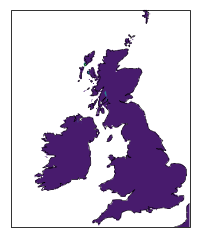

In [28]:
iplt.contourf(masked_cube[0])
plt.gca().coastlines(resolution='50m', color='black', linewidth=0.5);

In [32]:
print(masked_cube.coord('time')[0])
print(masked_cube.coord('time')[-1])

DimCoord([2000-06-01 00:15:00], bounds=[[2000-06-01 00:00:00, 2000-06-01 00:30:00]], standard_name='time', calendar='360_day', var_name='time')
DimCoord([2020-08-30 23:45:00], bounds=[[2020-08-30 23:30:00, 2020-09-01 00:00:00]], standard_name='time', calendar='360_day', var_name='time')


In [46]:
# Add a year ctaegory
iris.coord_categorisation.add_year(masked_cube, 'time', name='year')
# Apply the constraint to select years from 2001 to 2019 inclusive
cube_constrained = model_cube_jja.extract(iris.Constraint(year=lambda cell: cell in list(range(2001, 2020))))
print(cube_constrained.coord('time'))

AuxCoord(array([2000, 2000, 2000, ..., 2020, 2020, 2020]), standard_name=None, units=Unit('1'), long_name='year')

In [52]:
# print(cube_constrained.coord('time'))

### Save as cube

In [35]:
iris.save(masked_cube, ddir + 'maskedcube.nc')

In [53]:
print(f"Min value is {np.nanmin(cube_constrained.data)}")

MemoryError: Unable to allocate 67.1 GiB for an array with shape (82080, 519, 423) and data type float32

### Create post 2000 version

In [ ]:
compressed = cube_constrained.data.compressed()
compressed.shape[0]

In [2]:
################################################################
# Split cube into 2 parts, otherwise to big to hold in memory
################################################################ 
first_half = model_cube_jja[:47520, :,:]
second_half = model_cube_jja[47520:, :,:] 

################################################################
### Get associated times
################################################################
times_1sthalf = first_half.coord('time')   
times_2ndhalf = second_half.coord('time')   
np.save(f"ProcessedData/TimeSeries/UKCP18_every30mins/{resolution}/{yrs_range}/timestamps_uptil2010.npy", times_1sthalf) 
np.save(f"ProcessedData/TimeSeries/UKCP18_every30mins/{resolution}/{yrs_range}/timestamps_2010onwards.npy", times_2ndhalf)

### Check end of each half of data makes sense
#print(times_2ndhalf.units.num2date(times_2ndhalf.points[-1]))
#print(times_1sthalf.units.num2date(times_1sthalf.points[-1]))

cube_names = ['uptil2010', '2010onwards']
for cube_number, cube in enumerate([first_half, second_half]):

    ################################################################
    # Get data as array
    ################################################################      
    start = time.time()
    data = cube.data.data
    end= time.time()
    print(f"Time taken to load cube {round((end-start)/60,1)} minutes" )    

    start = time.time()
    flattened_data = data.flatten()
    end= time.time()
    print(f"Time taken to flatten cube {round((end-start)/60,1)} minutes" )

    ### Save as numpy array
    print("saving data")
    if trim_to_leeds == True:
        np.save(ddir + "leeds-at-centre_jja.npy", flattened_data)   
    else:
        np.save(ddir + f"uk_jja.npy_{cube_names[cube_number]}", flattened_data) 
    print("saved data")

NameError: name 'model_cube_jja' is not defined

In [96]:
################################################################
### Get associated times
################################################################
times_1sthalf = first_half.coord('time')   
times_2ndhalf = second_half.coord('time')   
np.save(f"ProcessedData/TimeSeries/UKCP18_every30mins/{resolution}/{yrs_range}/timestamps_uptil2010.npy", times_1sthalf) 
np.save(f"ProcessedData/TimeSeries/UKCP18_every30mins/{resolution}/{yrs_range}/timestamps_2010onwards.npy", times_2ndhalf)

### Check end of each half of data makes sense
#print(times_2ndhalf.units.num2date(times_2ndhalf.points[-1]))
#print(times_1sthalf.units.num2date(times_1sthalf.points[-1]))

cube_names = ['2010onwards']
for cube_number, cube in enumerate([second_half]):

    ################################################################
    # Get data as array
    ################################################################      
    start = time.time()
    data = cube.data.data
    end= time.time()
    print(f"Time taken to load cube {round((end-start)/60,1)} minutes" )    

    start = time.time()
    flattened_data = data.flatten()
    end= time.time()
    print(f"Time taken to flatten cube {round((end-start)/60,1)} minutes" )

    ### Save as numpy array
    print("saving data")
    if trim_to_leeds == True:
        np.save(ddir + "leeds-at-centre_jja.npy", flattened_data)   
    else:
        np.save(ddir + f"uk_jja.npy_{cube_names[cube_number]}", flattened_data) 
    print("saved data")

Time taken to load cube 11.1 minutes
Time taken to flatten cube 0.6 minutes
saving data
saved data


In [129]:
# np.nanmin(cube[5000,:,:].data.min())
np.nanmin(data)


-158.4497

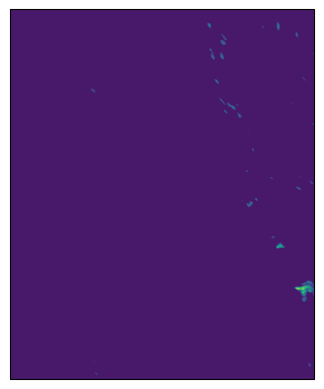

In [120]:
iplt.contourf(cube[5000,:,:])

In [102]:
flattened_data.shape

(9483998400,)

In [111]:
flattened_data

array([7.6662013e-07, 1.4816558e-06, 7.5020708e-08, ..., 2.4915999e-01,
       4.8647329e-01, 7.5875932e-01], dtype=float32)

In [116]:
lsm_nn.data

masked_array(
  data=[[0.0, 0.0, 0.0, ..., 1.0, 1.0, 1.0],
        [0.0, 0.0, 0.0, ..., 1.0, 1.0, 1.0],
        [0.0, 0.0, 0.0, ..., 1.0, 1.0, 1.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)